In [1]:
from helper_functions import *
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

In [2]:
# Unpickle Data
path = "./compressed_data/cf/"
train_file_path = path + "train_32_16_4_8.dat"
valid_file_path = path + "valid_32_16_4_8.dat"
test_file_path = path + "test_32_16_4_8.dat"
x_train, y_train = unpack_pickle(train_file_path)
x_valid, y_valid = unpack_pickle(valid_file_path)
x_test, y_test = unpack_pickle(test_file_path)

print("Train Image")
see_images(x_train[0], y_train[0])
x_image_shape = x_train[0].shape
y_image_shape = y_train[0].shape
print("X Train Image Shape:", x_image_shape)
print("Y Train Image Shape:", y_image_shape)

print("Valid Image")
see_images(x_valid[0], y_valid[0])
x_image_shape = x_valid[0].shape
y_image_shape = y_train[0].shape
print("X Valid Image Shape:", x_image_shape)
print("Y VaLid Image Shape:", y_image_shape)


print("Test Image")
see_images(x_test[0], y_test[0])
x_image_shape = x_test[0].shape
y_image_shape = y_test[0].shape
print("X Test Image Shape:", x_image_shape)
print("Y Test Image Shape:", y_image_shape)






FileNotFoundError: [Errno 2] No such file or directory: './data/train_32_16_4_8.dat'

In [ ]:
# Need to resize the numpy array, since Conv2D expects (number, rgb channels, x, y)

def prepare_data_for_dataset(x, y):
    x = np.stack( x, axis=0)
    x = x.swapaxes(1, 3)
    y = np.stack( y, axis=0)
    y = y.swapaxes(1, 3)
    return x, y

x_train, y_train = prepare_data_for_dataset(x_train, y_train)
print("x_train new dimensions:", x_train.shape)
print("y_train new dimensions:", y_train.shape)

x_valid, y_valid = prepare_data_for_dataset(x_valid, y_valid)
print("x_valid new dimensions:", x_valid.shape)
print("y_valid new dimensions:", y_valid.shape)

x_test, y_test = prepare_data_for_dataset(x_test, y_test)
print("x_test new dimensions:", x_valid.shape)
print("y_test new dimensions:", y_valid.shape)

x_train new dimensions: (45000, 3, 8, 8)
y_train new dimensions: (45000, 3, 32, 32)
x_valid new dimensions: (5000, 3, 8, 8)
y_valid new dimensions: (5000, 3, 32, 32)
x_test new dimensions: (5000, 3, 8, 8)
y_test new dimensions: (5000, 3, 32, 32)


In [ ]:
# Need to take images and place into dataset for easier use of data loader
class CompressionDataset(Dataset):
    def __init__(self, compressed_images, original_images, transforms=None) -> None:
        self.original = original_images
        self.compressed = compressed_images
        if transforms != None: 
            for transform in transforms:
                self.original = transform(self.original)
                self.compressed = transform(self.compressed)
        super().__init__()
    def __len__(self):
        return len(self.original)
    def __getitem__(self, index):
        original_image = self.original[index]
        compressed_image = self.compressed[index]
        sample = {"Compressed":compressed_image, "Original":original_image}
        return sample


def ToTensor(array):
    return torch.from_numpy(array).float()


Train Image <class 'torch.Tensor'>
Test Image <class 'torch.Tensor'>
tensor(86.)


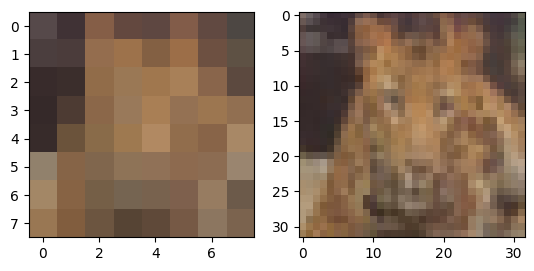

test tensor(208.5625)


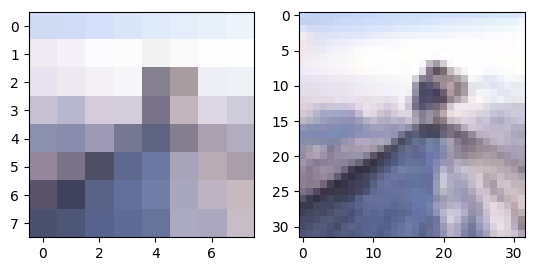

In [ ]:

# Convert each set of images to a dataset

train_data_set = CompressionDataset(x_train, y_train, transforms= [ToTensor])
valid_data_set = CompressionDataset(x_valid, y_valid, transforms=[ToTensor])
test_data_set = CompressionDataset(x_test, y_test, transforms=[ToTensor])
batch_size = 5

image = train_data_set.compressed[0]

print("Train Image", type(image[0][0][0]))

image = test_data_set.compressed[0]
print("Test Image", type(image[0][0][0]))

train_data_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=False)
valid_data_loader = DataLoader(valid_data_set, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data_set, batch_size=batch_size, shuffle=False)

#Testing Data Loader to see if it got our data correctly
for (idx, batch) in enumerate(train_data_loader):
    print(batch["Compressed"][0][0][0][0])
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

for (idx, batch) in enumerate(test_data_loader):
    print("test",batch["Compressed"][0][0][0][0])
    see_images(batch["Compressed"][0].swapaxes(0, 2), batch["Original"][0].swapaxes(0, 2))
    break # We just want first image in batch

In [ ]:
class CNNNet(nn.Module):
    def __init__(self) -> None:
        super(CNNNet, self).__init__()
        self.conv1 =  nn.ConvTranspose2d(3, 40, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(40, 3, 4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(40) 
        self.batchnorm2 = nn.BatchNorm2d(3)

# https://towardsdatascience.com/what-is-transposed-convolutional-layer-40e5e6e31c11#:~:text=Transposed%20convolutions%20are%20standard%20convolutions,in%20a%20standard%20convolution%20operation.
    def forward(self, x):
        x = self.batchnorm1(func.relu(self.conv1(x)))
        x = self.batchnorm2(func.relu(self.conv2(x)))
        return func.log_softmax(x)

# Test to see if it was working! 
for (idx, batch) in enumerate(train_data_loader):
    in_image = batch["Compressed"]
    test_net = CNNNet()
    test_image = test_net.forward(in_image)
    print(test_image)
    break


tensor([[[[-0.5947, -1.0068, -0.8338,  ..., -1.0684, -0.7941, -1.2224],
          [-0.5175, -1.6245, -0.5837,  ..., -1.8813, -0.5577, -1.0185],
          [-0.4546, -1.2313, -0.6861,  ..., -1.3970, -0.8891, -1.0097],
          ...,
          [-0.6083, -1.9339, -1.2427,  ..., -1.6456, -1.0185, -1.0185],
          [-0.7945, -0.6750, -0.5406,  ..., -0.9331, -0.3993, -0.9461],
          [-1.2554, -1.1842, -1.1783,  ..., -0.9485, -0.6593, -1.0185]],

         [[-1.5118, -1.4288, -1.2144,  ..., -0.8661, -1.2460, -1.2948],
          [-1.5509, -0.6955, -1.2104,  ..., -0.5099, -1.7831, -1.0927],
          [-1.8836, -0.7706, -0.9431,  ..., -0.6073, -0.8566, -1.0977],
          ...,
          [-1.8762, -0.3069, -0.4648,  ..., -0.2562, -1.0927, -1.0927],
          [-1.7057, -1.4963, -1.2624,  ..., -1.8464, -1.7557, -1.1360],
          [-1.3947, -1.2584, -1.0820,  ..., -1.1345, -1.3728, -1.0927]],

         [[-1.4795, -0.9288, -1.3140,  ..., -1.4444, -1.3456, -0.8404],
          [-1.6505, -1.1901, -

C:\Users\Trenton Wallis\AppData\Local\Temp\ipykernel_14660\2129722972.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return func.log_softmax(x)


In [ ]:
# Ripped this part off of (will make a custom one later): https://nextjournal.com/gkoehler/pytorch-mnist
train_losses = []
train_counter = []
test_losses = []
n_epochs = 5
momentum = 0.5
learning_rate = 0.1
log_interval = 10
network = CNNNet()
test_counter = [i*len(train_data_loader.dataset) for i in range(n_epochs + 1)]
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)



def train(epoch):
  network.train()
  for idx, batch in enumerate(train_data_loader):
    optimizer.zero_grad()
    output = network(batch["Compressed"])
    loss_func = nn.MSELoss(reduction='sum')
    loss = loss_func(output, batch["Original"])
    loss.backward()
    optimizer.step()
    if idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, idx * len(batch["Compressed"]), len(train_data_loader.dataset),
        100. * idx / len(train_data_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (idx*64) + ((epoch-1)*len(train_data_loader.dataset)))
      torch.save(network.state_dict(), './train_model/baseline_test.pth')
      return 
      # torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test(): # Need to figure out how to evaluate based on loss
  network.eval()
  test_loss = 0
  correct = 0
  loss_func = nn.MSELoss(reduction='sum')
  with torch.no_grad():
    for idx, batch in enumerate(test_data_loader):
      output = network(batch["Compressed"])
      print("Loss:", loss_func(output,batch["Original"] ))
      for idx, image in enumerate(output):
        see_images(image.numpy().swapaxes(0, 2), batch["Original"][idx].numpy().swapaxes(0, 2))
      break

C:\Users\Trenton Wallis\AppData\Local\Temp\ipykernel_14660\2129722972.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return func.log_softmax(x)


Loss: tensor(2.7815e+08)


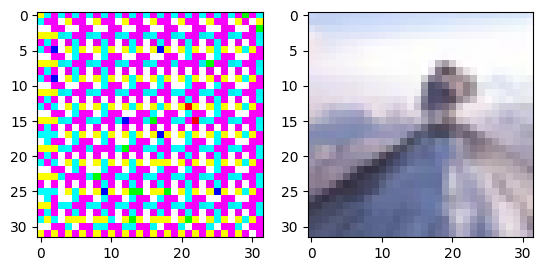

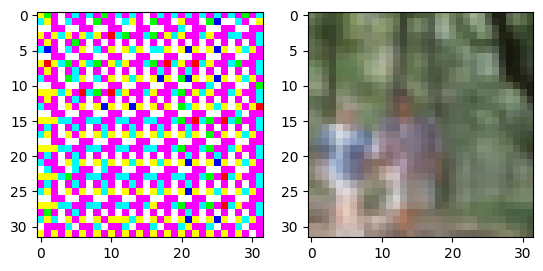

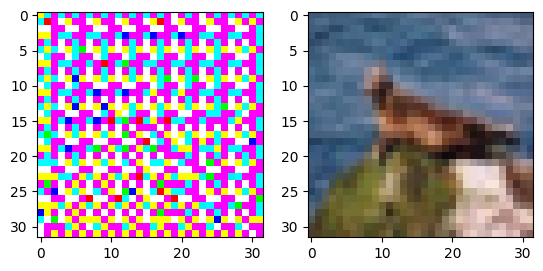

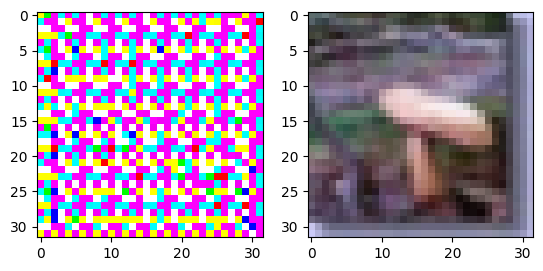

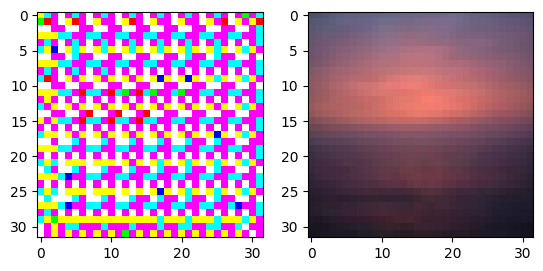

Train Epoch: 1 [0/45000 (0%)]	Loss: 258180640.000000
Train Epoch: 1 [50/45000 (0%)]	Loss: nan
Train Epoch: 1 [100/45000 (0%)]	Loss: nan
Train Epoch: 1 [150/45000 (0%)]	Loss: nan
Train Epoch: 1 [200/45000 (0%)]	Loss: nan
Train Epoch: 1 [250/45000 (1%)]	Loss: nan
Train Epoch: 1 [300/45000 (1%)]	Loss: nan
Train Epoch: 1 [350/45000 (1%)]	Loss: nan
Train Epoch: 1 [400/45000 (1%)]	Loss: nan
Train Epoch: 1 [450/45000 (1%)]	Loss: nan
Train Epoch: 1 [500/45000 (1%)]	Loss: nan
Train Epoch: 1 [550/45000 (1%)]	Loss: nan
Train Epoch: 1 [600/45000 (1%)]	Loss: nan
Train Epoch: 1 [650/45000 (1%)]	Loss: nan
Train Epoch: 1 [700/45000 (2%)]	Loss: nan
Train Epoch: 1 [750/45000 (2%)]	Loss: nan
Train Epoch: 1 [800/45000 (2%)]	Loss: nan
Train Epoch: 1 [850/45000 (2%)]	Loss: nan
Train Epoch: 1 [900/45000 (2%)]	Loss: nan
Train Epoch: 1 [950/45000 (2%)]	Loss: nan
Train Epoch: 1 [1000/45000 (2%)]	Loss: nan
Train Epoch: 1 [1050/45000 (2%)]	Loss: nan
Train Epoch: 1 [1100/45000 (2%)]	Loss: nan
Train Epoch: 1 [1150/

c:\Users\Trenton Wallis\Documents\NCState\Classes\ECE_792\ece792project\helper_functions.py:38: RuntimeWarning: invalid value encountered in cast
  plt.imshow(np.array(left_image).astype(np.uint8), interpolation='none')


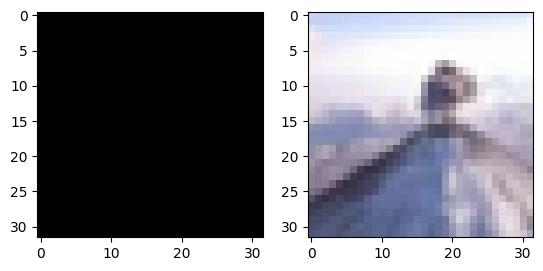

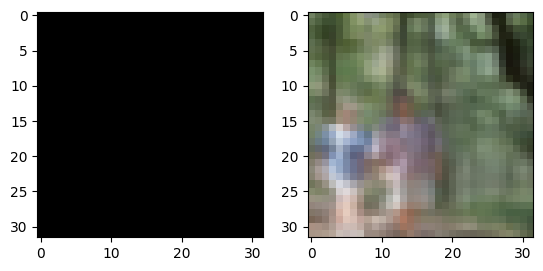

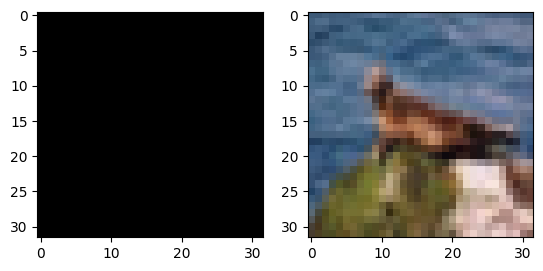

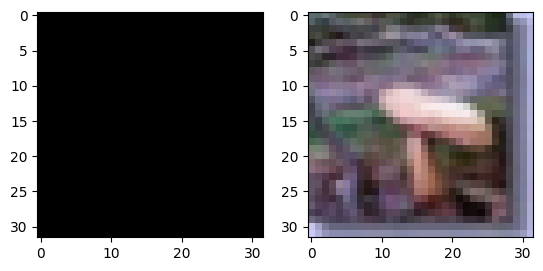

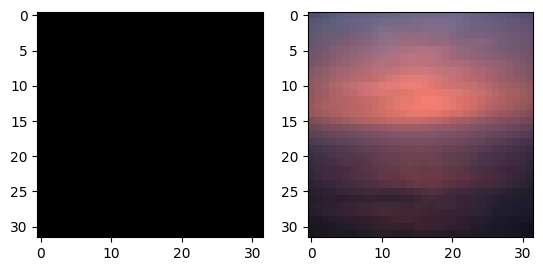

TypeError: 'Tensor' object is not callable

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  input() # DELETE THIS TO CONTINUE TRAINING!